# Proyecto, predicción de datos a partir de modelo previamente generado
## Álvaro Andrés Esquivel Gómez 11002822

In [72]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from joblib import dump, load
from sklearn import datasets
from sklearn.utils import resample
from sklearn import svm
from sklearn import tree
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy import array, exp
import pandas as pd
import tensorflow as tf
import math
from scipy import stats
import collections


In [73]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


### Importando datos

In [52]:
#Importando los datos
data = pd.read_csv (r'data_titanic_proyecto.csv')
data.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


In [53]:
#Quitando variables que no aportan informacion al modelo
data = data.drop(['PassengerId', 'Fare', 'Name', 'Ticket', 'Cabin'], axis=1)
print(data.shape)
data.head()
#entrenamiento, validacion = train_test_split(data, test_size=0.80, random_state=10)

(891, 7)


,Age,SibSp,Parch,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,1,0,S,Lower,M,N
1,38.0,1,0,C,Upper,F,Y
2,26.0,0,0,S,Lower,F,Y
3,35.0,1,0,S,Upper,F,Y
4,35.0,0,0,S,Lower,M,N


In [54]:
#Remplaza valores NaN con 0
data["Age"] = data["Age"].replace(np.nan, 0)
print(data.info())
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 891 non-null    float64
 1   SibSp               891 non-null    int64  
 2   Parch               891 non-null    int64  
 3   Embarked            889 non-null    object 
 4   passenger_class     891 non-null    object 
 5   passenger_sex       891 non-null    object 
 6   passenger_survived  891 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 48.9+ KB
None


(891, 7)

In [55]:
#Elimina los valores vacios
data = data.fillna(data['Embarked'].value_counts().index[0])
#print(cat_data.isnull().sum())
print(data['Embarked'].value_counts(),"\n", data['passenger_class'].value_counts(),"\n", 
      data['passenger_sex'].value_counts(),"\n", data['passenger_survived'].value_counts())

S    646
C    168
Q     77
Name: Embarked, dtype: int64 
 Lower     491
Upper     216
Middle    184
Name: passenger_class, dtype: int64 
 M    577
F    314
Name: passenger_sex, dtype: int64 
 N    549
Y    342
Name: passenger_survived, dtype: int64


In [56]:
#Remplazando valores categoricos
replace_map = {'Embarked': {'S': 1, 'C': 2, 'Q': 3}, 'passenger_class': {'Lower': 1, 'Middle': 2, 'Upper': 3}, 
               'passenger_sex': {'F': 0, 'M': 1}, 'passenger_survived': {'N': 0, 'Y': 1}}
data.replace(replace_map, inplace=True)

data.head(10)

,Age,SibSp,Parch,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,1,0,1,1,1,0
1,38.0,1,0,2,3,0,1
2,26.0,0,0,1,1,0,1
3,35.0,1,0,1,3,0,1
4,35.0,0,0,1,1,1,0
5,0.0,0,0,3,1,1,0
6,54.0,0,0,1,3,1,0
7,2.0,3,1,1,1,1,0
8,27.0,0,2,1,1,0,1
9,14.0,1,0,2,2,0,1


In [57]:
train, test = train_test_split(data, test_size=0.20, random_state = 10)
train, validation = train_test_split(train, test_size=0.20, random_state = 10)
print("Train:", train.shape, "test:", test.shape, "validation:", validation.shape)

Train: (569, 7) test: (179, 7) validation: (143, 7)


### Funcion calculo de evaluaciones y agrega a matriz

In [58]:
def validacion_resultados(y_test, y_hat):

    error_squared = mean_squared_error(y_test, y_hat)
    print("error_squared:", error_squared)
    acc_reg_log = accuracy_score(y_test, y_hat)
    print("accuracy o exactitud", acc_reg_log)
    porcentaje_error = 1 - acc_reg_log
    print("porcentaje de error", porcentaje_error)
    p_score = precision_score(y_test, y_hat, average='binary')
    print("precision_score", p_score)
    r_score = recall_score(y_test, y_hat, average='binary')
    print("recall_score", r_score)
    f_score = f1_score(y_test, y_hat, average='binary')
    print("f1 score", f_score)


# Predicción de datos a partir de archivo cargado


### Usando datos entrenados mediante Árbol de decisión en archivo generador

In [83]:
#Seleccion de dataos x de prueba
x_test = test.iloc[:, test.columns != "passenger_survived"]
y_test = test.iloc[:, test.columns == "passenger_survived"]

#Importacion de archivo para generacion de prediccion
classifi = load('decision_tree_20200629-203130.joblib') 

y_pred = classifi.predict(x_test).astype(int)

print("Prediccion\n", y_pred)

print("Validacion resultados del modelo")
validacion_resultados(y_test, y_pred)


Prediccion
 [0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1
 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1
 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0]
Validacion resultados del modelo
error_squared: 0.20670391061452514
accuracy o exactitud 0.7932960893854749
porcentaje de error 0.2067039106145251
precision_score 0.6984126984126984
recall_score 0.7096774193548387
f1 score 0.704


In [84]:
x_unica_prediccion = np.array([[35.0, 0, 0, 1, 1, 1]])
x_unica_prediccion

y_unica_prediccion = classifi.predict(x_unica_prediccion).astype(int)
y_unica_prediccion

array([0])

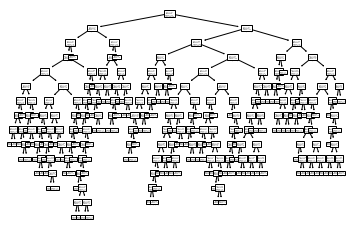

In [85]:
from sklearn.datasets import load_iris
iris = load_iris()
tree.plot_tree(classifi);

### Usando datos entrenados mediante SVM en archivo generador

In [25]:
#Seleccion de dataos x de prueba
x_test = test.iloc[:, test.columns != "passenger_survived"]
y_test = test.iloc[:, test.columns == "passenger_survived"]

#Importacion de archivo para generacion de prediccion
regressor = load('SVM_sklearn_20200629-173945.joblib') 

y_pred = regressor.predict(x_test).astype(int)

print("Prediccion\n", y_pred)

print("Validacion resultados del modelo")
validacion_resultados(y_test, y_pred)

Prediccion
 [0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0]
Validacion resultados del modelo
error_squared: 0.1787709497206704
accuracy o exactitud 0.8212290502793296
porcentaje de error 0.17877094972067042
precision_score 0.7678571428571429
recall_score 0.6935483870967742
f1 score 0.7288135593220338


### Usando datos entrenados mediante Tensorflow en archivo generador

In [27]:
#Cargar parametros del entrenamiento 
parametros_entrenados = np.load('log_reg_20200629-180809_lr=0.01_epochs=50.npy') 

parametros_entrenados.shape

(111, 2)

In [44]:
X_data = data.iloc[:, data.columns != "passenger_survived"]
Y_data = data.iloc[:, data.columns == "passenger_survived"]   
#One hot
oneHot = OneHotEncoder() 
#print("X_train\n", X_train, X_train.shape)
#print("Y_train\n", Y_train, Y_train.shape)
# Encoding x_orig 
oneHot.fit(X_data) 
X_data = oneHot.transform(X_data).toarray() 
  
# Encoding y_orig 
oneHot.fit(Y_data) 
Y_data = oneHot.transform(Y_data).toarray() 
print("X_data\n", X_data, X_data.shape)
print("Y_data\n", Y_data, Y_data.shape)

x_train, x_test = train_test_split(X_data, test_size=0.20, random_state = 10)
x_train, x_validation = train_test_split(x_train, test_size=0.20, random_state = 10)
print("x_train:", x_train.shape, "x_test:", x_test.shape, "x_validation:", x_validation.shape)

num_mat = np.matmul(x_test, parametros_entrenados)

predic = 1 / (1 + exp(-num_mat))

print("predicción probabilística:", predic)

#print(y_test)
predic[0:predic.shape[0],]
resultado = []
for i in range(predic.shape[0]):
    if predic[i, 0] > predic[i, 1]:
        resultado.append(0)
    else:
        resultado.append(1)

print(resultado)
Y_data = data.iloc[:, data.columns == "passenger_survived"]  
y_train, y_test = train_test_split(Y_data, test_size=0.20, random_state = 10)
y_train, y_validation = train_test_split(y_train, test_size=0.20, random_state = 10)

validacion_resultados(y_test, resultado)


X_data
 [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]] (891, 111)
Y_data
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]] (891, 2)
x_train: (569, 111) x_test: (179, 111) x_validation: (143, 111)
predicción probabilística: [[0.96685247 0.00355835]
 [0.97263558 0.00287711]
 [0.9676336  0.00308426]
 [0.0080384  0.95153957]
 [0.01798568 0.88261559]
 [0.96737869 0.00352441]
 [0.97114097 0.00290594]
 [0.88103887 0.03596496]
 [0.97245916 0.00272468]
 [0.9683797  0.00326329]
 [0.86054017 0.03802425]
 [0.01057789 0.94659435]
 [0.04472307 0.87278025]
 [0.78860322 0.04081784]
 [0.85108081 0.04143594]
 [0.89213391 0.02910866]
 [0.97866941 0.00234691]
 [0.92006891 0.01082682]
 [0.20349453 0.24171476]
 [0.91135573 0.00781358]
 [0.96436492 0.00263255]
 [0.55654371 0.13181622]
 [0.04012482 0.8233684 ]
 [0.95280836 0.00346784]
 [0.88642376 0.01074249]
 [0.97263558 0.00287711]
 [0.972